In [1]:
!pip install descartes

  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# import geopandas 
# import geoplot
from shapely.geometry import Point, Polygon
from sklearn.preprocessing import StandardScaler

In [3]:
# df = pd.read_csv('merged_med_seasonal_2011_2016.csv').drop(columns='Unnamed: 0')
df = pd.read_csv('state_nerged_aggregated_.csv').drop(columns=['Unnamed: 0'])

In [5]:
df[['AYEAR','death']].groupby('AYEAR').mean()

,death
AYEAR,
2011.0,611.180071
2012.0,618.467685
2013.0,636.834516
2014.0,643.576880
2015.0,666.272249
2016.0,669.785717


In [6]:
import geopandas

world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

In [7]:
us_map = world[world.name == 'United States of America']

In [1]:
f, ax = plt.subplots(1, figsize=(12, 12))
ax = us_map.plot(ax=ax, color='white', edgecolor='black')
gis_states = geopandas.read_file('tl_2011_us_state/tl_2011_us_state.shp')

polygon = Polygon([(0, 0), (0, 90), (180, 90), (180, 0), (0, 0)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=world.crs)

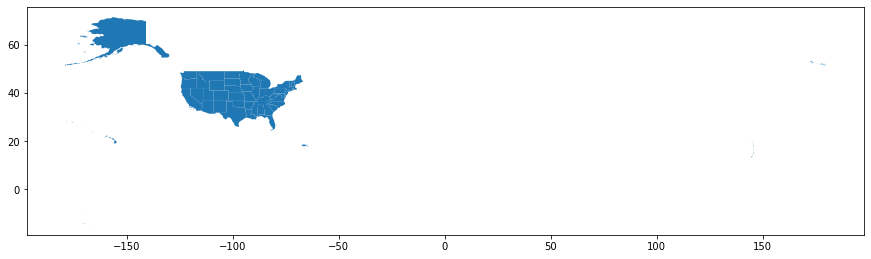

In [12]:
gis_states.plot(figsize=(15,25))
plt.show()

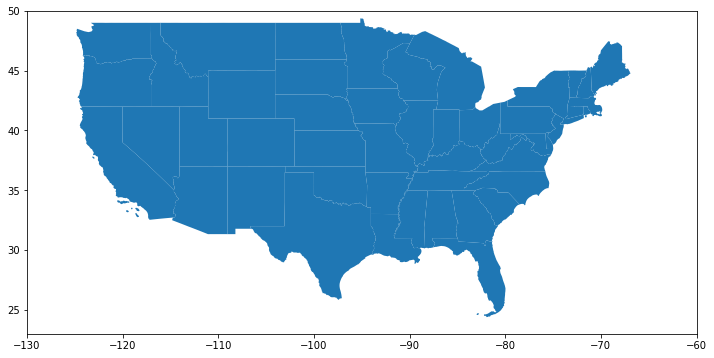

In [15]:
s = list(gis_states.NAME.values)
for i in ['American Samoa','United States Virgin Islands','Commonwealth of the Northern Mariana Islands',
         'Puerto Rico', 'Guam','Alaska', 'Hawaii']:
    s.remove(i)
s52 = gis_states[gis_states.NAME.isin(s)]

f, ax = plt.subplots(1, figsize=(12, 12))
ax = s52.plot(ax=ax) #, color='white', edgecolor='black'
plt.xlim(-130,-60)
plt.ylim(23,50)
plt.show()

In [16]:
# http://darribas.org/gds15/content/labs/lab_03.html
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac

In [2]:
# df[['statecode','zip','AYEAR','population','death']].head(10)

In [33]:
# states_count = df[['statecode','zip','AYEAR','population','death']].groupby(['statecode','zip']).aggregate(agg).reset_index()
# states_count2 = states_count.groupby(['statecode']).aggregate(agg).reset_index()#.reset_index().drop(columns=['AYEAR'])
# states_count['death/pop'] =states_count.death/states_count.population
# states_merged1 = pd.merge(s52, states_count, how='left', left_on='STUSPS', right_on='statecode')

In [34]:
states_avg = df[['statecode','AYEAR','population','death']].groupby(['statecode']).mean().reset_index().drop(columns=['AYEAR'])
states_avg['death/pop'] =states_avg.death/states_avg.population
states_merged = pd.merge(s52, states_avg, how='left', left_on='STUSPS', right_on='statecode')

In [82]:
# count deaths for each state per year
df_agg = df[['statecode','AYEAR', 'death', 'population']].groupby(['statecode','AYEAR']).sum().reset_index()

# average numbmer of deaths per state accross years
df_agg2 = df_agg.groupby(['statecode']).mean().drop(columns=['AYEAR']).reset_index()
states_merged_v2 = pd.merge(s52, df_agg2, how='left', left_on='STUSPS', right_on='statecode')

In [63]:
states_2011 = df[df.AYEAR==2011]
deaths_2011 = states_2011[['statecode', 'death', 'population']].reset_index().drop(columns=['index']).groupby('statecode').mean().reset_index()

deaths_2011['death/pop'] = deaths_2011.death/deaths_2011.population
states_merged_2011 = pd.merge(s52, deaths_2011, how='left', left_on='STUSPS', right_on='statecode')

In [55]:
def plot_death_count(states_merged,save=False):
    # set the range for the choropleth
    vmin, vmax = min(states_merged['death']), max(states_merged['death'])

    f, ax = plt.subplots(1, figsize=(10, 4))
    ax = states_merged.plot(ax=ax, column='death', cmap='BuGn', edgecolor='black') #, color='white', edgecolor='black'
    ax.axis('off')


    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    # sm._A = []
    # add the colorbar to the figure
    cbar = f.colorbar(sm, ax=ax)

    plt.title('US Average Death Count (2011-2016)', fontdict={'fontsize': '15', 'fontweight' : '3'})
    plt.xlim(-130,-60)
    plt.ylim(23,50)
    plt.show()
    
    if save:
        f.savefig('us_avg_death_count.png', dpi=300)
#         f.savefig('us_avg_death.png', dpi=300)

In [37]:
def plot_states_yearly(df,s52):
    for year in [2011,2012,2013,2014,2015,2016]:
        states_sub = df[df.AYEAR==year]
        deaths_sub = states_sub[['statecode', 'death', 'population']].reset_index().drop(columns=['index'])
        # stanndardize
        deaths_sub['death/pop'] = deaths_sub.death/deaths_sub.population
        
        states_merged_sub = pd.merge(s52, deaths_sub, how='left', left_on='STUSPS', right_on='statecode')
        
        plot_death_count(states_merged_sub)

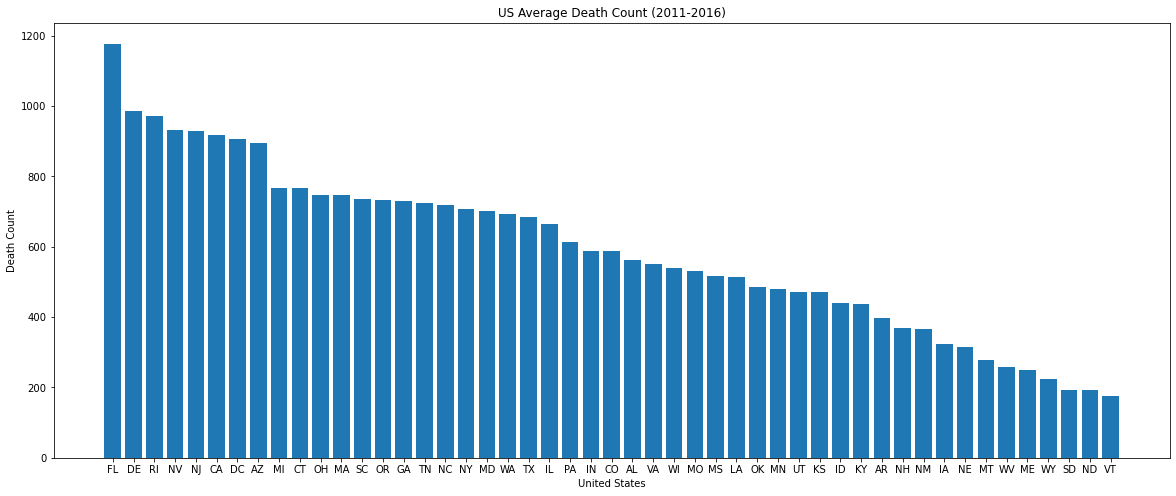

In [54]:
f, axs = plt.subplots(1,1,figsize=(20,8))
states_avg2 = states_merged.sort_values(by=['death'],ascending=False)
axs.bar(states_avg2['statecode'], states_avg2['death'])
# plt.figure(figsize=(10,5))
axs.set_xlabel('United States')
axs.set_ylabel('Death Count')
axs.set_title('US Average Death Count (2011-2016)')
# f.savefig('us_avg_death_bar.png', dpi=300)
plt.show()

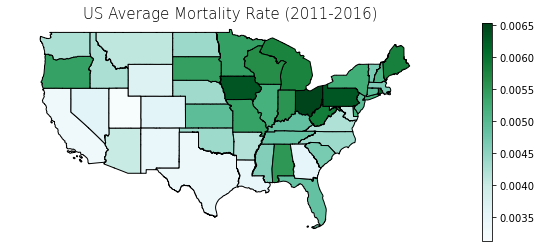

In [29]:
plot_death_count(states_merged, save=True)

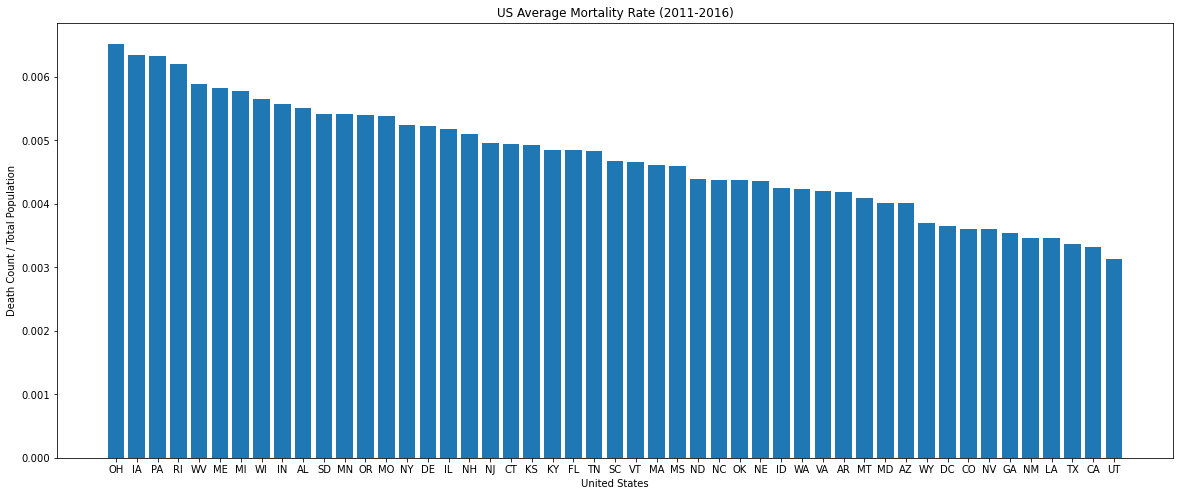

In [30]:
f, axs = plt.subplots(1,1,figsize=(20,8))
states_avg2 = states_avg.sort_values(by=['death/pop'],ascending=False)
axs.bar(states_avg2['statecode'], states_avg2['death/pop'])
# plt.figure(figsize=(10,5))
axs.set_xlabel('United States')
axs.set_ylabel('Death Count / Total Population')
axs.set_title('US Average Mortality Rate (2011-2016)')
f.savefig('us_avg_death_bar.png', dpi=300)
plt.show()

In [32]:
cols_to_plot = ['statecode','pm25_summer_4y_avg', 'pm25_winter_4y_avg',
       'pm25_fall_4y_avg', 'pm25_spring_4y_avg', 'ozone_summer_4y_avg',
       'ozone_winter_4y_avg', 'ozone_fall_4y_avg', 'ozone_spring_4y_avg',
       'no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg',
       'no2_spring_4y_avg', 'summer_tmmx_4y_avg', 'summer_rmax_4y_avg',
       'winter_tmmx_4y_avg', 'winter_rmax_4y_avg', 'death']

states_env = df[['statecode', 'AYEAR','pm25_summer_4y_avg', 'pm25_winter_4y_avg',
       'pm25_fall_4y_avg', 'pm25_spring_4y_avg']].groupby(['statecode','AYEAR']).mean().reset_index() #.drop(columns=['AYEAR'])


In [33]:
print('summer ',states_env[states_env.pm25_summer_4y_avg==max(states_env.pm25_summer_4y_avg)].statecode)
print('spring ',states_env[states_env.pm25_spring_4y_avg==max(states_env.pm25_spring_4y_avg)].statecode)
print('winter ',states_env[states_env.pm25_winter_4y_avg==max(states_env.pm25_winter_4y_avg)].statecode)
print('fall ',states_env[states_env.pm25_fall_4y_avg==max(states_env.pm25_fall_4y_avg)].statecode)

summer  36    DC
Name: statecode, dtype: object
spring  54    GA
Name: statecode, dtype: object
winter  72    IL
Name: statecode, dtype: object
fall  0    AL
Name: statecode, dtype: object


In [42]:
df_sub2= df[['AYEAR', 'pm25_summer_4y_avg','pm25_winter_4y_avg',
    'pm25_fall_4y_avg', 'pm25_spring_4y_avg']].groupby('AYEAR').mean().reset_index()

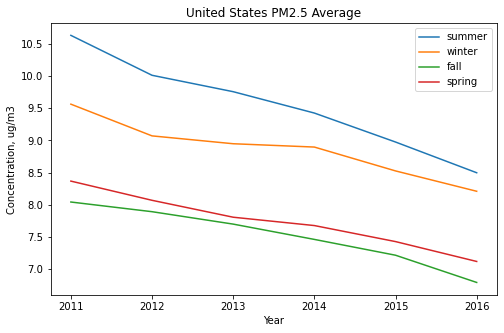

In [44]:
f,ax = plt.subplots(1,figsize=(8,5)) 
ax.plot(df_sub2['AYEAR'], df_sub2['pm25_summer_4y_avg'], label='summer')
ax.plot(df_sub2['AYEAR'], df_sub2['pm25_winter_4y_avg'], label='winter')
ax.plot(df_sub2['AYEAR'], df_sub2['pm25_fall_4y_avg'], label='fall')
ax.plot(df_sub2['AYEAR'], df_sub2['pm25_spring_4y_avg'], label='spring')
# plt.hlines(y=12, xmin=2011, xmax=2016, linestyles='dashed')
ax.set_title('United States PM2.5 Average')
ax.set_xlabel('Year')
ax.set_ylabel('Concentration, ug/m3')
plt.legend()
plt.show() 
f.savefig('us_yearly_pm.png')

In [ ]:
# standardize by population (density)
# def standardize_by_pop(df):
#     scaler = StandardScaler().fit(df.population.values.reshape(-1, 1))
#     scaled_pop = list(scaler.transform(df.population.values.reshape(-1, 1)).reshape((49,)))
#     scaled_deaths = list(scaler.transform(df.death.values.reshape(-1, 1)).reshape((49,)))
    
#     df['population'] = scaled_pop
#     df['death'] = scaled_deaths

# standardize_by_pop(states_avg)